## U-NET

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import PIL
from PIL import Image


### GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and Dataloader

Setear la ubicación del dataset. Puedo bajar el dataset Carvana desde Kaggle.

https://www.kaggle.com/competitions/carvana-image-masking-challenge/data

Download los siguientes archivos zip: train.zip, train_masks.zip y test.zip

Extraerlos en sus respectivas carpetas.

In [11]:
PATH = './dataset'
TRAIN_PATH = './dataset/train/'
TRAIN_MASKS_PATH = './dataset/train_masks/'
TEST_PATH = './dataset/test/'

#### Dataset

In [6]:
# creamos nuestro propio dataset (hereada de la clase Dataset de Pytorch)
class Car_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        
        #son paths
        self.path_train_data = data
        self.path_train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.path_train_data))  #lista ordenada de imágenes
        self.masks = sorted(os.listdir(self.path_train_masks))  #lista ordenada de máscaras
        
    def __len__(self):
        if self.path_train_masks is not None: #si hay máscaras, veo que tengan mismo tamaño que la lista de imagenes
            assert len(self.images)==len(self.masks), 'no coinciden el número de imágenes y de máscaras'
        return len(self.images)
         
    def __getitem__(self, idx): #devuelve un elemento del dataset en la posición idx
        image_name = os.path.join(self.path_train_data, self.images[idx]) #path completo de la imagen
        img = Image.open(image_name) #abro la imagen
        trans = T.ToTensor()

        if self.img_transforms is not None: #si hay transformaciones de imágenes
            img = self.img_transforms(img)  #aplico las transformaciones a las imágenes
        else:
            img =trans(img)  #convierto a tensor
        
        if self.path_train_masks is not None: #si hay máscaras
            mask_name = os.path.join(self.path_train_masks, self.masks[idx])
            mask = Image.open(mask_name)

            if self.mask_transforms is not None: #si hay transformaciones de máscaras
                mask = self.mask_transforms(mask) #aplico las transformaciones a las máscaras
            else:
                mask = trans(mask)  #convierto a tensor
            
            #normalizo a [0,1]
            mask_max = mask.max().item()
            mask /= mask_max
        else: #si  no existen las máscaras, sólo devuelvo las imágenes (ej. testing set)
            return img
        
        return img, mask            

#### Transformaciones

In [7]:
#Genero una serie de transormaciones
transform_data = T.Compose([
                T.Resize([224, 224]),  #224x224
                T.ToTensor()] )

#### Dataloaders

In [12]:
full_dataset = Car_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [13]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

In [14]:
print(TRAIN_SIZE, VAL_SIZE)

4070 1018


In [15]:
#hago un split 80% train, 20% val
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [16]:
print(len(train_dataset), len(val_dataset))

4070 1018


In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


In [19]:
for i, (x, y) in enumerate(train_loader): #i: mini-batches
    print(i, x.shape, y.shape)
    if i==9: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


#### Visualizamos los datos

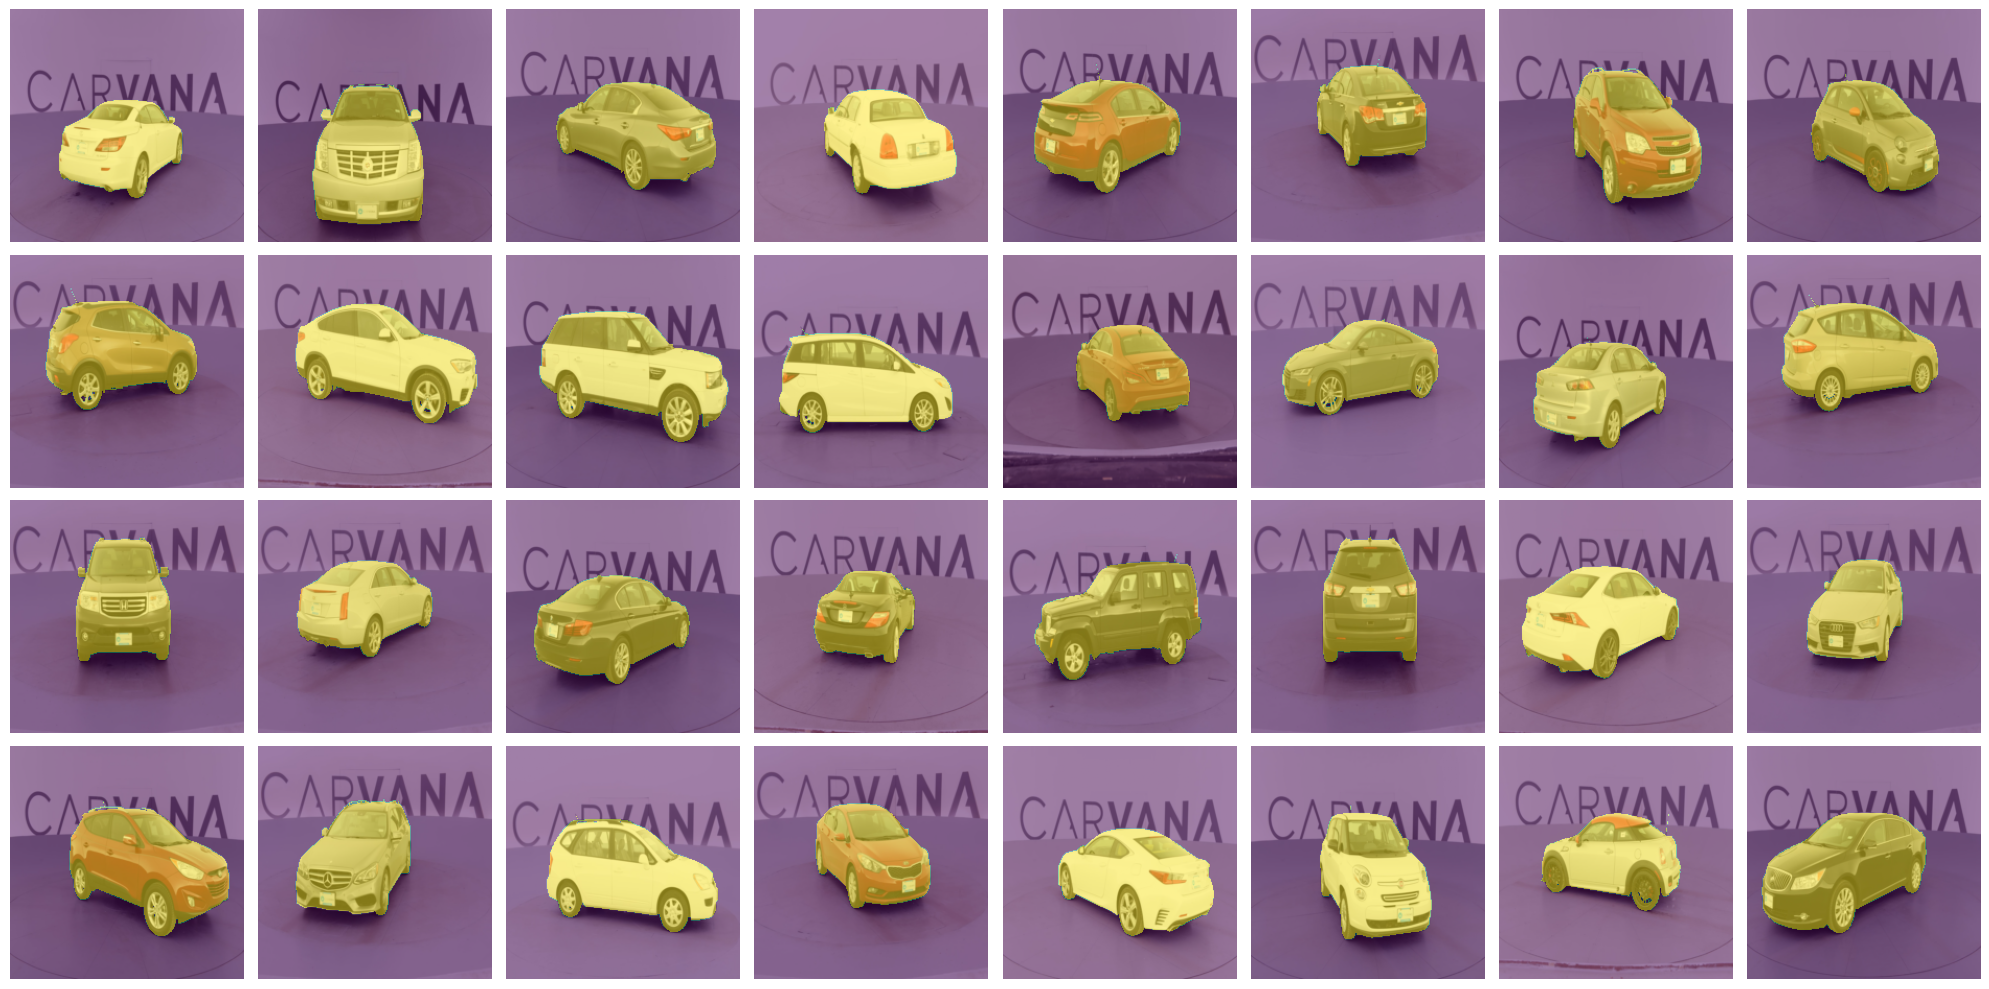

In [20]:
imgs, masks = next(iter(train_loader))

def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))  #4x8
    
    for i in range(BATCH_SIZE):  #BS = 32
        plt.subplot(4, 8, i+1)   #primer posición es 1
        img=imgs[i,...].permute(1,2,0).numpy()  #... ellipsis, de la posición i tomame todas los canales, el tensor está organizado c,h,w, permuto h,w,c
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)  #controlo la opacificidad con alpha
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

### Accuracy

In [21]:
def accuracy(model, loader):
    correct = 0
    intersection = 0  #numerador del IoU
    denom_dice = 0  #denominador del coef. de Sørensen-Dice (estadística utilizada para medir la similitud de dos muestras)
    denom_iou = 0  #denominador del IoU
    total = 0  #total de pixeles clasificados de forma correcta
    cost = 0.

    model = model.to(device=device)

    with torch.no_grad():   #no calculamos gradientes
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item() #item devuelve el valor escalar del tensor
            
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum() #sumamos todos los pixeles correctos de todas las imágenes en el dataset de validación
            total += torch.numel(preds) #sumamos todos los pixeles de todas las imágenes en el dataset de validación
            #el accuracy se calcula una sola vez para todo el dataset de validación, no tenemos que resetear

            #Dice coefficient
            intersection += (preds*y).sum()  #intersección es equivalente a lo que nos dá el modelo (preds) y la máscara (acumulamos para todas las imágenes)
            denom_dice += (preds + y).sum()
            dice = 2*intersection/(denom_dice + 1e-8) #evitamos división por cero usando un número pequeño

            #IoU: intersection over union
            denom_iou += (preds + y - preds*y).sum()  #acumulo la unión (preds+y) -intersección (preds*y)
            iou = (intersection)/(denom_iou + 1e-8)  #evitamos división por cero usando un número pequeño
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [22]:
len(train_loader)

128

#### Busqueda del mejor learning rate (1-cycle learning rate policy)

In [23]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val

    optimiser.param_groups[0]['lr'] = lr #permite actualizar el learning rate

    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []

    model = model.to(device=device)

    for i, (x, y) in enumerate(loader, start=1): #inicio en 1 para evitar divisiones por cero
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)

        optimiser.zero_grad()  #reseteamos los gradientes, no queremos que los acumule
        scores = model(x)

        #calculamos el cost y lo acumulamos en forma exponencial ponderada
        cost = F.cross_entropy(input=scores, target=y)

        loss = beta*loss + (1-beta)*cost.item()

        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        #calculamos el accuracy
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)

#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop

        if i > 1 and avg_loss > 4 * lowest_loss: #si la pérdida es muy grande, no salimos, no vale la pena seguir
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies

        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item()) #acc es un tensor

#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)

        #step
        cost.backward()
        optimiser.step()

        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor #actualizo el learning rate y lo seteo en el optimiser
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Loop de entrenamiento 

In [24]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device) #pasamos el modelo a GPU
    train_acc_history=[]
    train_cost_history=[]

    for epoch in range(epochs): 
        train_correct_num = 0  #reseteamos en cada epoch
        train_total = 0  #numero de elemento evaluados
        train_cost_acum = 0.  #para visualizar el acumulado del costo

        for mb, (x, y) in enumerate(train_loader, start=1):  
            model.train() #para cada minibatch (mb) ponemos el modelo en modo entrenamiento porque luego lo cambiamos a modo evaluación, "y" es [32, 1, 224, 224], 
            # debemos quitar el canal (dim=1) (uso squeeze) --> queda [32, 224, 224]

            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)  #para poder calcular la fución de costo
            
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()  #reseteamos los gradientes en el caso que haya gradientes acumulados
            cost.backward() #calculamos los gradientes
            optimiser.step() #damos un step, actualizamos nuestros parámetros de la red neuronal
            
            if scheduler: 
                scheduler.step()  #si usamos un scheduler, damos un step para actualizar el valor del learning rate

            # Hasta acá es la función de entrenamiento, luego vamos a evaluar el progreso del entrenamiento (queremos ver que accuracy crezca y costos disminuyan)

            #scores nos devuelve dos canales (2 matrices), uno para c/clase
            train_predictions = torch.argmax(scores, dim=1)  #me quedo con el canal que tiene el mayor valor, a través de la dimensión del canal
            
            train_correct_num += (train_predictions == y).sum()  #acumulamos las predicciones que son correctas, ambas matrices son 224x224, ambas con valores [0,1] ME suma aquellos píxeles que coinciden
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()  #es un tensor de pytorch, con item extraemos el valor

            #va a guardar cada 25 iteraciones
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader) #METRICAS
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb   #mb es iteraciones

                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'  #con 4 decimales
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
                # Save data
                train_acc_history.append(train_acc)
                train_cost_history.append(train_cost_every)

        train_acc = float(train_correct_num)/train_total
        train_cost_every = float(train_cost_acum)/len(train_loader)
        
        return train_acc_history, train_cost_history    

### Modelo U-Net

In [25]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        return self.conv1(x)

In [28]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__() #llamamos al super de la clase que estamos heredando
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        #encuentra las features 
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2), #size 2x2 y stride=2 (reduce a la mitad)
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224  (64 canales, 224x224)
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128,  112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)
        

In [29]:
# función de prueba para ver si las dimensiones son correctas
def test():
    x = torch.randn((32, 3, 224, 224)) #dimensiones de un minibatch
    model = UNET(3, 64, 2)
    return model(x)

In [30]:
preds = test()

In [31]:
print(preds.shape)

torch.Size([32, 2, 224, 224])


### Entranamiento del modelo

In [32]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.8054, lr: 0.0000, acc: 0.1887
cost:0.7961, lr: 0.0000, acc: 0.1926
cost:0.7872, lr: 0.0000, acc: 0.2080
cost:0.7934, lr: 0.0000, acc: 0.2007
cost:0.7960, lr: 0.0000, acc: 0.1965
cost:0.7910, lr: 0.0000, acc: 0.2019
cost:0.7997, lr: 0.0000, acc: 0.1913
cost:0.7982, lr: 0.0000, acc: 0.1933
cost:0.7960, lr: 0.0000, acc: 0.1949
cost:0.8019, lr: 0.0000, acc: 0.1902
cost:0.8037, lr: 0.0000, acc: 0.1920
cost:0.8028, lr: 0.0000, acc: 0.1891
cost:0.7909, lr: 0.0000, acc: 0.2001
cost:0.7883, lr: 0.0000, acc: 0.2042
cost:0.7980, lr: 0.0000, acc: 0.1994
cost:0.8004, lr: 0.0000, acc: 0.1925
cost:0.7920, lr: 0.0000, acc: 0.1996
cost:0.7874, lr: 0.0000, acc: 0.2064
cost:0.7909, lr: 0.0000, acc: 0.1986
cost:0.8072, lr: 0.0000, acc: 0.1849
cost:0.7979, lr: 0.0000, acc: 0.1922
cost:0.7879, lr: 0.0000, acc: 0.2050
cost:0.7937, lr: 0.0000, acc: 0.1975
cost:0.7953, lr: 0.0000, acc: 0.1949
cost:0.7920, lr: 0.0000, acc: 0.2002
cost:0.7951, lr: 0.0000, acc: 0.1938
cost:0.8041, lr: 0.0000, acc: 0.1868
c

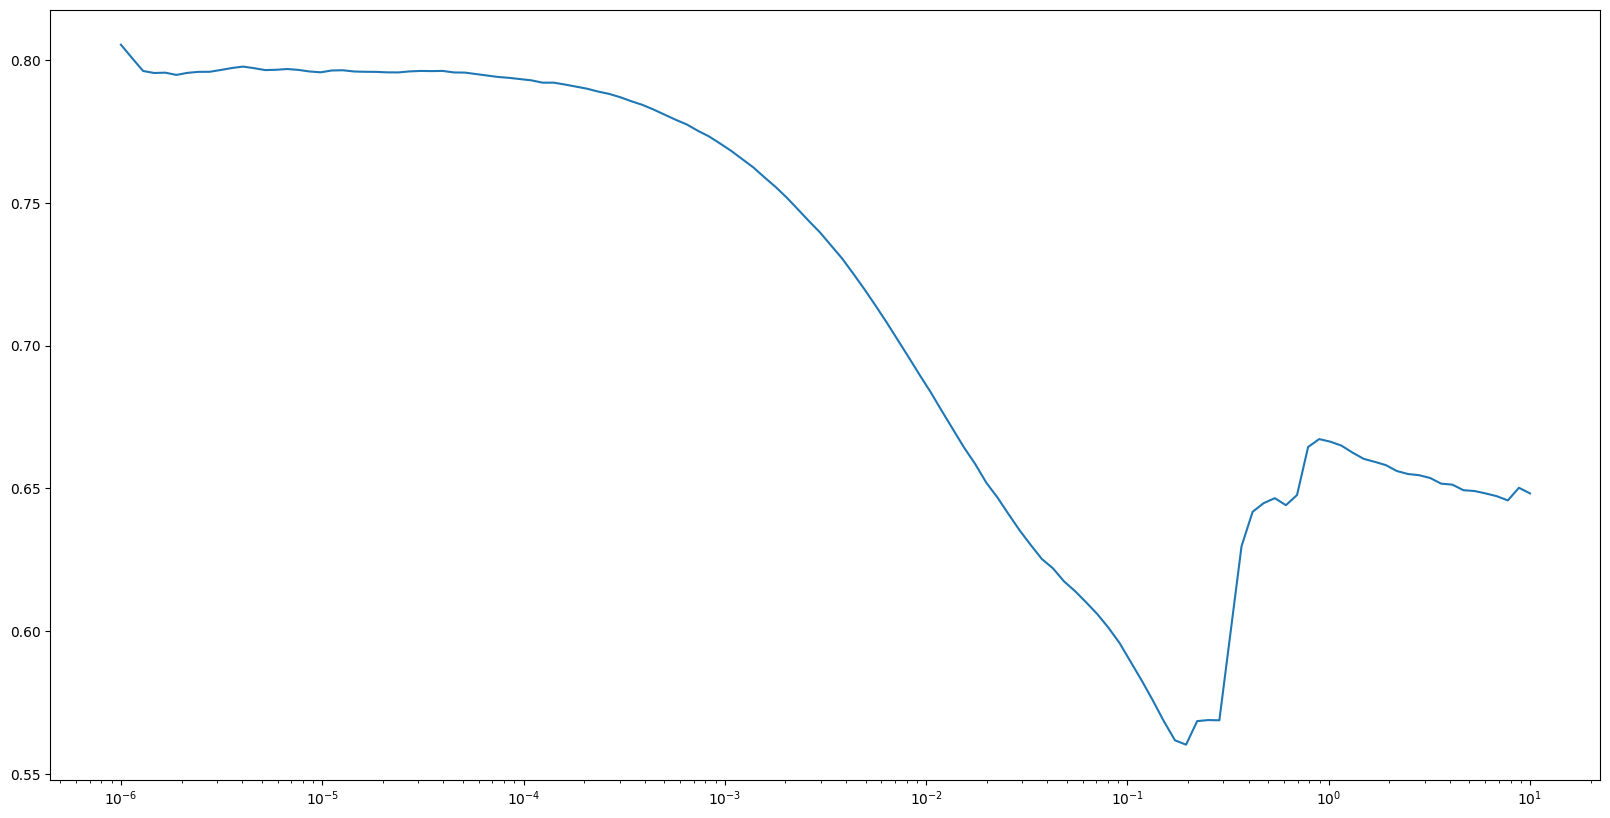

In [33]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [34]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 5

optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,  #lo sacamos de la gráfica
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, 
                                                pct_start=0.43, #porcentaje de inicio
                                                div_factor=10, 
                                                final_div_factor=1000,
                                                three_phase=True)

In [35]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 25, train cost: 0.4921, val cost: 0.2823,train acc: 0.7358, val acc: 0.8788,dice: 0.6286201477050781, iou: 0.4583851099014282
epoch: 0, mb: 50, train cost: 0.3463, val cost: 0.1077,train acc: 0.8230, val acc: 0.9665,dice: 0.9195563793182373, iou: 0.8510914444923401
epoch: 0, mb: 75, train cost: 0.2564, val cost: 0.0553,train acc: 0.8726, val acc: 0.9787,dice: 0.9499874711036682, iou: 0.9047391414642334
epoch: 0, mb: 100, train cost: 0.2051, val cost: 0.0485,train acc: 0.8994, val acc: 0.9800,dice: 0.9526018500328064, iou: 0.9094935059547424
epoch: 0, mb: 125, train cost: 0.1720, val cost: 0.0332,train acc: 0.9164, val acc: 0.9868,dice: 0.9689844846725464, iou: 0.9398349523544312


([0.7357776377152423,
  0.8229823770328444,
  0.8725948245509141,
  0.8994462616589605,
  0.9164094587053572],
 [0.49205741643905637,
  0.346262047290802,
  0.25642641762892404,
  0.20506573867052794,
  0.1719555650949478])

### Ploteo algunas imágenes

torch.Size([32, 224, 224])


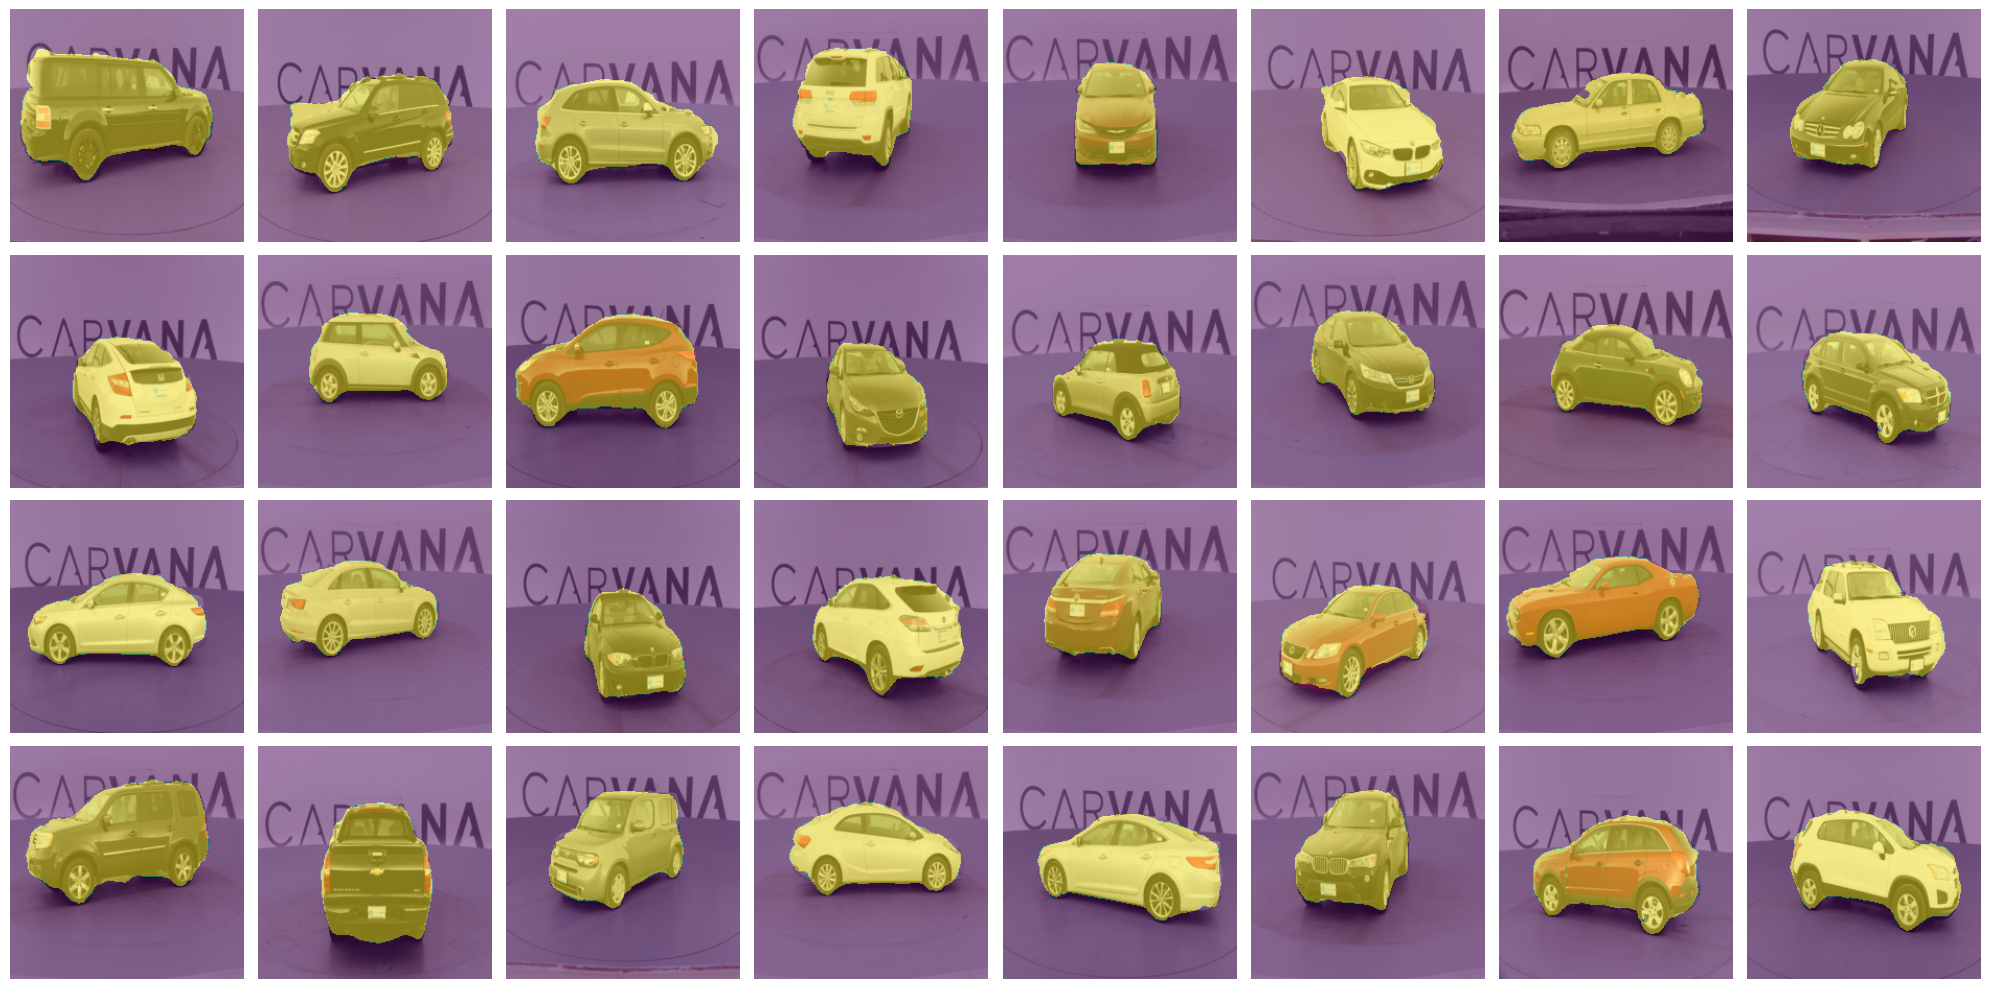

In [36]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)

model = model.to(device)

with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()

print(preds.shape)

plot_mini_batch(imgs_val, preds.unsqueeze(1)) #imagen y la máscara que arroja el modelo

In [37]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 224, 224])


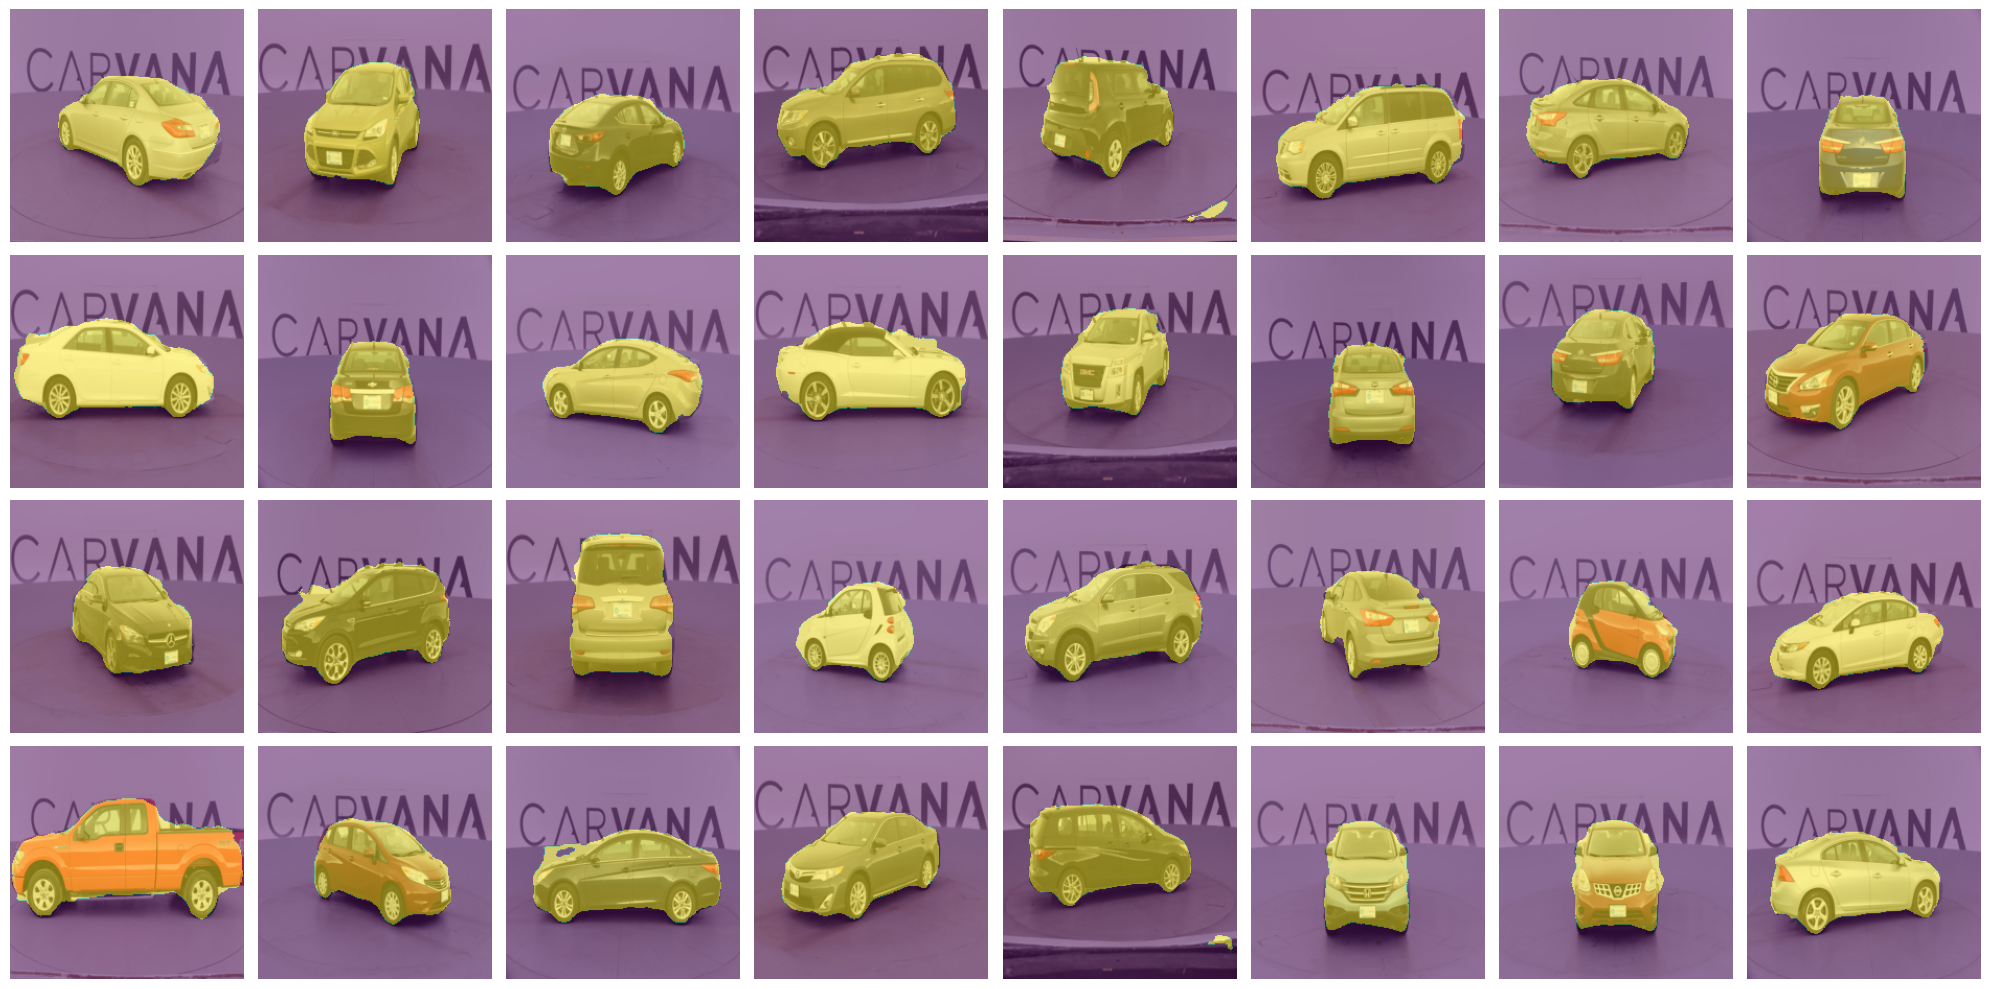

In [38]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)

model = model.to(device)

with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()

print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))